In [1]:
greetings = "Assalam-o-Alaikum!"
print(greetings)

Assalam-o-Alaikum!


### Import Libraries

In [29]:
import warnings
warnings.filterwarnings("ignore")


from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB


import numpy as np
import pandas as pd
import re

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import seaborn as sns
import matplotlib.pyplot as plt

### Import Dataset

In [3]:
df = pd.read_csv("ufo_sightings_large.csv")
df[:3]

,date,city,state,country,type,seconds,length_of_time,desc,recorded,lat,long
0,11/3/2011 19:21,woodville,wi,us,unknown,1209600.0,2 weeks,Red blinking objects similar to airplanes or s...,12/12/2011,44.9530556,-92.291111
1,10/3/2004 19:05,cleveland,oh,us,circle,30.0,30sec.,Many fighter jets flying towards UFO,10/27/2004,41.4994444,-81.695556
2,9/25/2009 21:00,coon rapids,mn,us,cigar,0.0,NaN,Green&#44 red&#44 and blue pulses of light tha...,12/12/2009,45.1200000,-93.287500


**Data Information**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4935 entries, 0 to 4934
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            4935 non-null   object 
 1   city            4926 non-null   object 
 2   state           4516 non-null   object 
 3   country         4255 non-null   object 
 4   type            4776 non-null   object 
 5   seconds         4935 non-null   float64
 6   length_of_time  4792 non-null   object 
 7   desc            4932 non-null   object 
 8   recorded        4935 non-null   object 
 9   lat             4935 non-null   object 
 10  long            4935 non-null   float64
dtypes: float64(2), object(9)
memory usage: 424.2+ KB


In [5]:
# Change the date column to type datetime
df["date"] = pd.to_datetime(df["date"])
df[:3]

,date,city,state,country,type,seconds,length_of_time,desc,recorded,lat,long
0,2011-11-03 19:21:00,woodville,wi,us,unknown,1209600.0,2 weeks,Red blinking objects similar to airplanes or s...,12/12/2011,44.9530556,-92.291111
1,2004-10-03 19:05:00,cleveland,oh,us,circle,30.0,30sec.,Many fighter jets flying towards UFO,10/27/2004,41.4994444,-81.695556
2,2009-09-25 21:00:00,coon rapids,mn,us,cigar,0.0,NaN,Green&#44 red&#44 and blue pulses of light tha...,12/12/2009,45.1200000,-93.287500


**Dropping missing data**

In [6]:
# Check how many values are missing in the length_of_time, state, and type columns
df[["length_of_time", "state", "type"]].isnull().sum()

length_of_time    143
state             419
type              159
dtype: int64

In [7]:
# Keep only rows where length_of_time, state, and type are not null
df_nm = df[df["length_of_time"].notnull() &
           df["state"].notnull() &
           df["type"].notnull() &
           df["seconds"].notnull()]

# Print out the shape of the new dataset
df_nm.shape

(4283, 11)

### Extracting numbers from strings

In [8]:
def return_time(time_string):
    pattern = re.compile(r"\d+")
    
    num = re.match(pattern, time_string)
    if num is not None:
        return int(num.group(0))
    
# Apply the extraction to the length_of_time column
df_nm["minutes"] = df_nm["length_of_time"].apply(lambda x: return_time(x))
df_nm[["length_of_time", "minutes"]][:5]

,length_of_time,minutes
0,2 weeks,2.0
1,30sec.,30.0
3,about 5 minutes,NaN
4,2,2.0
5,10 minutes,10.0


### Identifying features for standardization

In [9]:
# Check the variance of the seconds and minutes columns
df_nm[["seconds", "minutes"]].var()

seconds    1.545212e+10
minutes    9.470577e+02
dtype: float64

In [10]:
# Log normalize the seconds column
df_nm["seconds_log"] = np.log(df_nm["seconds"])
df_nm["seconds_log"].var()

nan

### Encoding categorical variables

In [11]:
# Use Pandas to encode us values as 1 and others as 0
df_nm["country_enc"] = df_nm["country"].apply(lambda x: 1 if x == "us" else 0)
df_nm[:2]

,date,city,state,country,type,seconds,length_of_time,desc,recorded,lat,long,minutes,seconds_log,country_enc
0,2011-11-03 19:21:00,woodville,wi,us,unknown,1209600.0,2 weeks,Red blinking objects similar to airplanes or s...,12/12/2011,44.9530556,-92.291111,2.0,14.005800,1
1,2004-10-03 19:05:00,cleveland,oh,us,circle,30.0,30sec.,Many fighter jets flying towards UFO,10/27/2004,41.4994444,-81.695556,30.0,3.401197,1


In [12]:
# Print the number of unique type values
len(df_nm["type"].unique())

21

In [13]:
# Create a one-hot encoded set of the type values
type_set = pd.get_dummies(df_nm["type"])
df_nm = pd.concat([df_nm, type_set], axis = 1)
df_nm[:2]

,date,city,state,country,type,seconds,length_of_time,desc,recorded,lat,long,minutes,seconds_log,country_enc,changing,chevron,cigar,circle,cone,cross,cylinder,diamond,disk,egg,fireball,flash,formation,light,other,oval,rectangle,sphere,teardrop,triangle,unknown
0,2011-11-03 19:21:00,woodville,wi,us,unknown,1209600.0,2 weeks,Red blinking objects similar to airplanes or s...,12/12/2011,44.9530556,-92.291111,2.0,14.005800,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2004-10-03 19:05:00,cleveland,oh,us,circle,30.0,30sec.,Many fighter jets flying towards UFO,10/27/2004,41.4994444,-81.695556,30.0,3.401197,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Extract Features from dates

In [14]:
# Look at the first 5 rows of the date column
df_nm["date"].head()

0   2011-11-03 19:21:00
1   2004-10-03 19:05:00
3   2002-11-21 05:45:00
4   2010-08-19 12:55:00
5   2012-06-16 23:00:00
Name: date, dtype: datetime64[ns]

In [15]:
# Extract the month from the date column
df_nm["month"] = df_nm["date"].apply(lambda row: row.month)

# Extract the year from the date column
df_nm["year"] = df_nm["date"].apply(lambda row: row.year)

# Take a look at the head of all three columns
df_nm[["date", "month", "year"]].head()

,date,month,year
0,2011-11-03 19:21:00,11,2011
1,2004-10-03 19:05:00,10,2004
3,2002-11-21 05:45:00,11,2002
4,2010-08-19 12:55:00,8,2010
5,2012-06-16 23:00:00,6,2012


### Text vectorization

In [16]:
# Take a look at the head of the desc field
df_nm["desc"].head()

0    Red blinking objects similar to airplanes or s...
1                 Many fighter jets flying towards UFO
3    It was a large&#44 triangular shaped flying ob...
4       A white spinning disc in the shape of an oval.
5    Dancing lights that would fly around and then ...
Name: desc, dtype: object

In [17]:
# Create the tfidf vectorizer object
vec = TfidfVectorizer()

# Use vec's fit_transform method on the desc field
desc_tfidf = vec.fit_transform(df_nm["desc"])

# Look at the number of columns this creates
desc_tfidf.shape

(4283, 5754)

### Selecting the ideal dataset

In [18]:
# Make a list of features to drop
to_drop = ["city", "country", "desc", "date", "lat", "long", "length_of_time", "recorded", "state", "desc"]

# Drop those features
df_nm = df_nm.drop(to_drop, axis = 1)
df_nm[:2]

,type,seconds,minutes,seconds_log,country_enc,changing,chevron,cigar,circle,cone,cross,cylinder,diamond,disk,egg,fireball,flash,formation,light,other,oval,rectangle,sphere,teardrop,triangle,unknown,month,year
0,unknown,1209600.0,2.0,14.005800,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,11,2011
1,circle,30.0,30.0,3.401197,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,2004


**Exploring text vectors**

In [19]:
vocab = {v:k for k,v in vec.vocabulary_.items()}

In [20]:
# Add in the rest of the parameters
def return_weights(vocab, original_vocab, vector, vector_index, top_n):
    zipped = dict(zip(vector[vector_index].indices, vector[vector_index].data))
    
    # Let's transform that zipped dict into a series
    zipped_series = pd.Series({vocab[i]:zipped[i] for i in vector[vector_index].indices})
    
    # Let's sort the series to pull out the top n weighted words
    zipped_index = zipped_series.sort_values(ascending=False)[:top_n].index
    return [original_vocab[i] for i in zipped_index]

# Print out the weighted words
print(return_weights(vocab, vec.vocabulary_, desc_tfidf, 8, 3))

[3557, 5131, 1731]


In [21]:
def words_to_filter(vocab, original_vocab, vector, top_n):
    filter_list = []
    for i in range(0, vector.shape[0]):
    
        # Here we'll call the function from the previous exercise, and extend the list we're creating
        filtered = return_weights(vocab, original_vocab, vector, i, top_n)
        filter_list.extend(filtered)
    # Return the list in a set, so we don't get duplicate word indices
    return set(filter_list)

# Call the function to get the list of word indices
filtered_words = words_to_filter(vocab, vec.vocabulary_, desc_tfidf, top_n = 3)

# By converting filtered_words back to a list, we can use it to filter the columns in the text vector
filtered_text = desc_tfidf[:, list(filtered_words)]

### Modeling the UFO dataset

In [22]:
df_nm[:2]

,type,seconds,minutes,seconds_log,country_enc,changing,chevron,cigar,circle,cone,cross,cylinder,diamond,disk,egg,fireball,flash,formation,light,other,oval,rectangle,sphere,teardrop,triangle,unknown,month,year
0,unknown,1209600.0,2.0,14.005800,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,11,2011
1,circle,30.0,30.0,3.401197,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,2004


In [23]:
df_nm = df_nm.drop(["type", "seconds", "minutes", "seconds_log"], axis = 1)

In [24]:
# Features
X = df_nm.drop("country_enc", axis = 1)

# Target
y = df_nm["country_enc"]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    stratify = y)

knn = KNeighborsClassifier()

# Fit knn to the training sets
knn.fit(X_train, y_train)

knn.score(X_test, y_test)

y_pred = knn.predict(X_test)
pd.DataFrame({"Actual": y_test, "Predicted": y_pred})[:10]

,Actual,Predicted
1260,1,1
3130,1,1
2142,1,1
1940,1,1
94,1,0
2499,1,1
3231,1,1
2497,1,1
838,1,1
2953,1,1


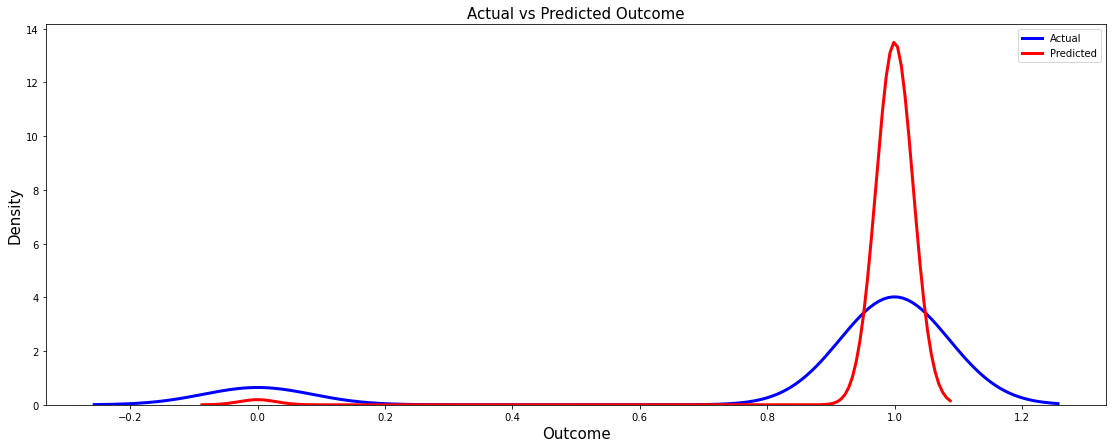

In [27]:
plt.figure(figsize = (19, 7))
sns.kdeplot(y_test, label = "Actual", linewidth = 3, color = "blue")
sns.kdeplot(x = y_pred, label = "Predicted", linewidth = 3, color = "red")
plt.title("Actual vs Predicted Outcome", size = 15)
plt.xlabel("Outcome", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

**Accuracy**

In [28]:
score = accuracy_score(y_test, y_pred)
score

0.8552754435107376

### Modeling the UFO dataset

In [33]:
# Use the list of filtered words we created to filter the text vector
filtered_text = desc_tfidf[:, list(filtered_words)]

# Split the X and y sets using train_test_split, setting stratify=y 
X_train, X_test, y_train, y_test = train_test_split(filtered_text.toarray(),
                                                    y,
                                                    stratify = y)
nb = GaussianNB()

# Fit nb to the training sets
nb.fit(X_train, y_train)

# Print the score of nb on the test sets
y_pred = nb.predict(X_test)
pd.DataFrame({"Actual": y_test, "Predicted": y_pred})[:10]

,Actual,Predicted
597,1,1
4581,1,1
1681,0,1
4908,1,0
2861,1,1
2917,0,1
965,1,1
1880,0,0
862,0,1
3855,1,1


**Accuracy**

In [34]:
score = accuracy_score(y_test, y_pred)
score

0.6311858076563959

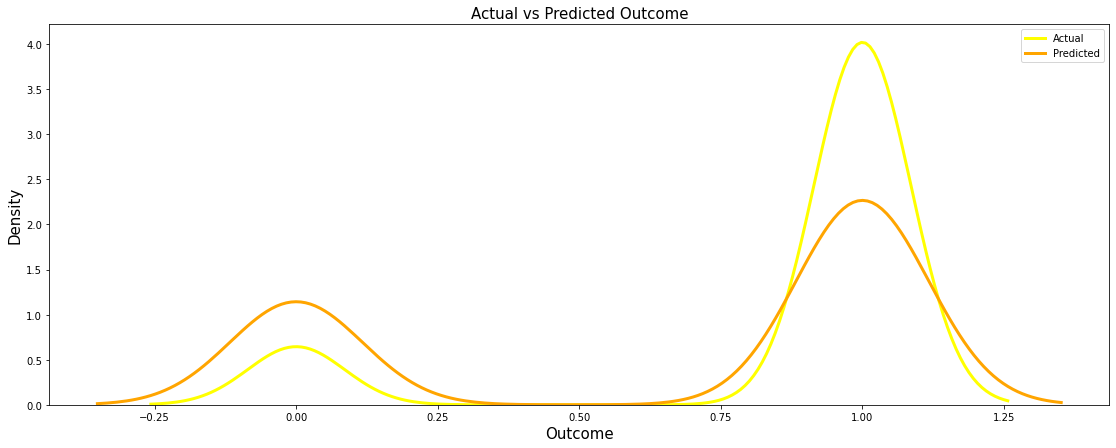

In [35]:
plt.figure(figsize = (19, 7))
sns.kdeplot(y_test, label = "Actual", linewidth = 3, color = "yellow")
sns.kdeplot(x = y_pred, label = "Predicted", linewidth = 3, color = "orange")
plt.title("Actual vs Predicted Outcome", size = 15)
plt.xlabel("Outcome", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()